In [1]:
using Pkg
Pkg.activate("../EEG_plots/env")

  Activating new project at `c:\Users\Vlad\Projects\EEG_plots\env`


In [ ]:
import Pkg; Pkg.add("PyMNE")

In [4]:
using Makie
using GLMakie
using PyMNE
using JLD2 # loading data
using StatsBase # mean/std
using Pipe


In [5]:
begin # load  one single-subject dataset 
	#p = "../../../../store/users/ehinger/projects/unfoldjl_dev/dev/UnfoldMakie/artifact/sub-002_ses-N170_task-N170_eeg.set"
	p = "data/sub-002_ses-N170_task-N170_eeg.set"
    raw = PyMNE.io.read_raw_eeglab(p,preload=true)
	#p_all = "../../../../store/users/ehinger/projects/unfoldjl_dev/data/erpcore-N170.jld2"
    p_all = "data/erpcore-N170.jld2"
	presaved_data = load(p_all)
	dat_e = presaved_data["data_e_all"].* 1e6
	evt_e = presaved_data["df_e_all"]
	mon = PyMNE.channels.make_standard_montage("standard_1020")
	raw.set_channel_types(Dict("HEOG_left"=>"eog","HEOG_right"=>"eog","VEOG_lower"=>"eog"))
	raw.set_montage(mon,match_case=false)
	pos = PyMNE.channels.make_eeg_layout(get_info(raw)).pos
	pos = [Point2f(pos[k,1],pos[k,2]) for k in 1:size(pos,1)]
end;

┌ Warning: type DataFrames.DataFrame does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Vlad\.julia\packages\JLD2\HnW0g\src\data\reconstructing_datatypes.jl:473
┌ Warning: type DataFrames.Index does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\Vlad\.julia\packages\JLD2\HnW0g\src\data\reconstructing_datatypes.jl:473


# 5. Topoplot array

# 5.1

In [8]:
# important functions for the main plot
function del_empt2(coord)
    # searching for unsued coordinates

    tmp = Array(minimum(coord):maximum(coord))
    unused = []
    for i in tmp
        if !(i in coord)
            append!(unused, i)
        end
    end
    
    # creation of new coordinates without empty ones
    newcoord = []
    for i in coord
        q = 0
        for j in unused  
            if i > j
                q = findall(x->x==j, unused)[1]
            end
        end
        append!(newcoord, i - q)
    end 
    newcoord
end

function del_empt(pos)
    x = [i[1] for i in pos]
    y = [i[2] for i in pos]
    
    x = round.(x; digits=2)
    y = Integer.(round.((y .- mean(y))  * 20)) * -1
    x = Integer.(round.((x .- mean(x))  * 20))

    newx = del_empt2(x)
    newy = del_empt2(y)

    # twiching the lateral electodes' positons
    ma = findall(xx->xx==maximum(newx), newx)[1]
    mi = findall(xx->xx==minimum(newx), newx)[1]
    newx[mi] = newx[mi] + 1
    newx[ma] = newx[ma] - 1
    # return
    newx, newy
end

del_empt (generic function with 1 method)

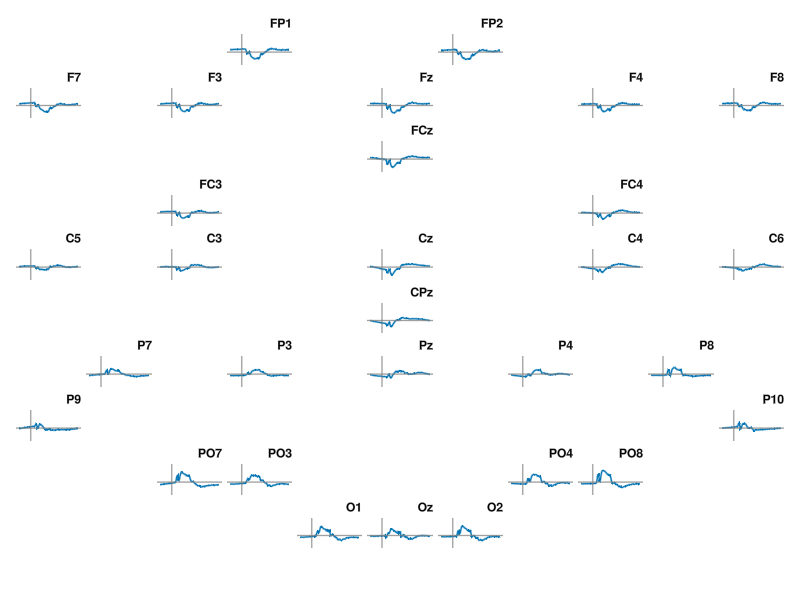

In [11]:
# the main plot
let 
    times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)
    f = Figure()
    gl = f[1, 1] = GridLayout()
    x, y = del_empt(pos)
    for i in 1:30
        col = x[i]
        row = y[i]

        if (row == -1 && col == 0)
            col = 1
        end
        if (row == -8 && col == 1)
            col = 2
        end
        ax = Axis(gl[row, col], title = raw.ch_names[i], #string(row, ' ',  col),
        titlealign = :right, titlesize = 12) # attribte for position 
        hidespines!(ax) 
        hidedecorations!(ax)
        voltage = mean(dat_e[i,:,:],dims=2)[:,1]
        lines!(times, voltage)
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        Makie.ylims!(low = -10, high = 14)
    end
    colgap!(gl, 5)
    rowgap!(gl, 5)
    f
    #save("plots/plot5.1.jpg", f)
end

# 5.2

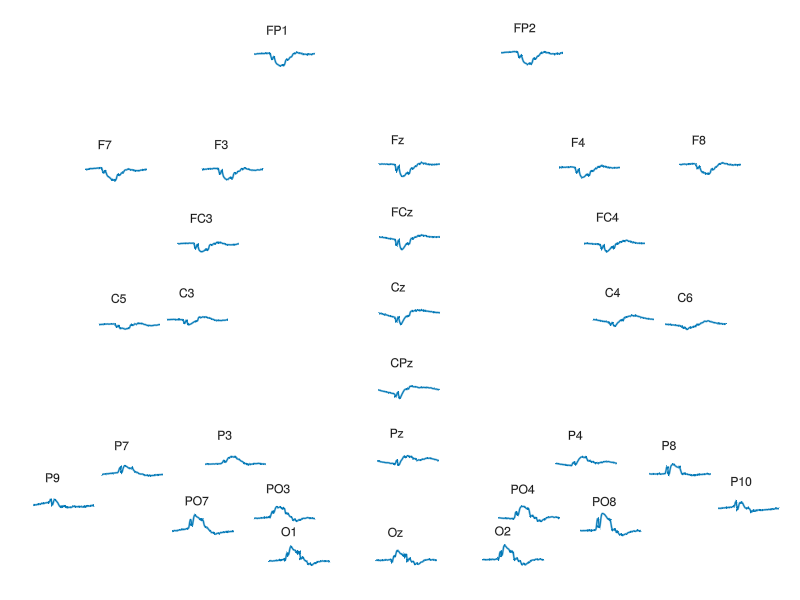

In [13]:
begin
    times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)
    fig = Figure()
    ax = Axis(fig[1, 1])

    i = 1
    Makie.xlims!(low = 20, high = 170)
    Makie.ylims!(low = 30, high = 200)
    
    xs = 0:0.01:10
    ys = 0.5 .* sin.(xs)

    xscale = 8
    yscale = 0.5
    
    for i in 1:30
        xmove = pos[i][1] * 200
        ymove =  pos[i][2] * 200 
        #println(raw.ch_names[i], " ", xmove, " ", ymove, " ")
        m4x4 = Makie.Mat4f(xscale, 0, 0, 0,
                        0, yscale, 0, 0,
                        0, 0, 1, 0,
                        xmove, ymove , 0, 1)
        voltage = mean(dat_e[i,:,:],dims=2)[:,1]
        lines!(times, voltage, model = m4x4, color = "#0077b6")
        text!(xmove, ymove + 6, text = raw.ch_names[i], 
        align = (:left, :bottom), color = :black,
        textsize = 12)
        #hlines!(xmove, color = :black, linewidth = 1, model = m4x4)
        vlines!(0,  xmin = minimum(voltage),
        xmax = maximum(voltage),  color = :red, linewidth = 1)
    end

    hidespines!(ax) 
    hidedecorations!(ax)
    fig
    #save("plots/plot5.svg", fig)
end

# 6

In [ ]:
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1:4, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    
    ax2 = Axis(ga[5, 1], xlabel = "Time [s]", ylabel = "Voltage [µV]")
    ys2 = mean(dat_e[28,:,ix],dims=2)[:,1]
    xs2 = range(-0.3, 1.2, length = size(dat_e, 2))
    lines!(ax2, xs2, ys2)
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.ylims!(-5, 10)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    
    CairoMakie.Colorbar(f[:, end+1], hm, label = "Voltage [µV]") 
    hidespines!(ax1, :t, :r)  
    hidespines!(ax2, :t, :r)  
    hidedecorations!(ax2, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots_jpg/plot6.jpg", f)
end